## Summary of the notebook

**train** **configuration** : <br> 
eager execution = disabled <br>


**process**: <br> 

1. Define the model in model_function()
2. Pass the model_function() and train, val and test data to the train function 
3. Pass the model_function and number_of_ensemble_components in the DeepEnsembleRegressor class arguments. Store this in an ensemble_model variable 
4. Apply .fit() on this ensemble variable 
Save the model (ensemble components) <br> 
5. Using the .predict_output() and passing the test data and number of estimators, obtain the prediction mean and prediction standard deviation 
6. Return the prediction mean, prediction std and the ensemble model from the train_model() 
7. Plot the prediction mean and +- 1 std against the ground truth in order to visualize the performance


**critical points and checklist** 

1. the script should yield a trained model folder 
2. pdfs and pngs in the output plots folder 
3. check model training configuration once


**analysis** 

1. for 2 ensemble components and a single input record (shape of single input row for CHD : (1,8)) :<br>
intermediate mean and std/var shape : (2, 1, 1) <br> 
final mean and std/var shape : (1, 1) 




## Mount the drive

In [ ]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting the correct path

In [ ]:
import os

project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'deep_ensemble'

%cd /content/drive/MyDrive/MasterThesis/ 

#print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
print(path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/


## Removing previous trained models

In [ ]:
import os
import shutil

test = os.listdir(path) 

#print(test)

for item in test:
    if item.endswith('.h5'):
        print(f'deleting {item}')
        shutil.rmtree(os.path.join(path, item))

## Imports

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

import os
import random 
import math

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

tf.compat.v1.disable_eager_execution()
print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

from keras.callbacks import ModelCheckpoint

np.set_printoptions(suppress=True)

2.8.2
Eager execution enabled : False


## regression_nll_loss

In [ ]:
import tensorflow as tf 

def regression_gaussian_nll_loss(variance_tensor, epsilon=1e-8, variance_logits=False):
    """
        Gaussian negative log-likelihood for regression, with variance estimated by the model.
        This function returns a keras regression loss, given a symbolic tensor for the sigma square output of the model.
        The training model should return the mean, while the testing/prediction model should return the mean and variance.
    """
    def nll(y_true, y_pred):
        #if variance_logits:
        #    variance_tensor = K.exp(variance_tensor)
        print('variance tensor ', K.function(variance_tensor, variance_tensor))
        print('log of variance tensor ', tf.math.log(variance_tensor+epsilon))

        return 0.5 * tf.math.reduce_mean(tf.math.log(variance_tensor + epsilon) + tf.math.square(y_true - y_pred) / (variance_tensor + epsilon))

    return nll

## Load data

In [ ]:
train_data, train_labels, val_data, val_labels, test_data, test_labels, feature_names = load_california_housing_data()

#print these values to test the load function 
print(train_data[20])
print(val_data[30])
print(test_data[40])

print(train_labels[20])
print(val_labels[30])
print(test_labels[40])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)
[0.33774161 0.54303932 0.68627451 0.02172137 0.0257604  0.01202388
 0.02450255 0.13793603]
[0.7440239  0.1256656  0.36       0.10962008 0.12527783 0.08111877
 0.10966623 0.07574378]
[0.50154799 0.38888889 0.2745098  0.05111024 0.0503969  0.08013412
 0.05783279 0.20159722]
[0.1816508]
[0.25773296]
[0.12732958]


## Class definition

### DeepEnsemble

In [ ]:
import keras
import numpy as np
import keras

import os
import yaml

from pydoc import locate
 
METADATA_FILENAME = "metadata.yml"

class DeepEnsemble:
    def __init__(self, model_fn=None, num_estimators=None, models=None, needs_test_estimators=False):
        self.needs_test_estimators = needs_test_estimators
        self.model_fn = model_fn
        self.num_estimators = num_estimators
        self.models = models

        if models is None:
            assert model_fn is not None and num_estimators is not None
            assert num_estimators > 0
            
            self.num_estimators = num_estimators
            self.train_estimators = [None] * num_estimators 
            self.test_estimators = [None] * num_estimators

            print('train_estimators : ', self.train_estimators)
            print('test_estimators : ', self.test_estimators)
            print('num_estimators : ', self.num_estimators)
            

            for i in range(self.num_estimators):
                if self.needs_test_estimators:
                    estimators = model_fn()

                    if type(estimators) is not tuple:
                        raise ValueError("model_fn should return a tuple")

                    if len(estimators) != 2:
                        raise ValueError("model_fn returned a tuple of unexpected size ({} vs 2)".format(len(estimators)))

                    train_est, test_est = estimators
                    self.train_estimators[i] = train_est
                    self.test_estimators[i] = test_est
                else:
                    est = model_fn()
                    print('len of est ', len(est))
                    self.train_estimators[i] = est[0]  # since model function returns 2 models, [0] = train mode and [1] = test/prediction model
                    self.test_estimators[i] = est[1]
                    #print(f'train_estimators[{i}] : {est}')
                    #print(f'test_estimators[{i}] : {est}')

        else:
            if (model_fn is None and num_estimators is None):   # assert raises error with integer value for num_estimators   # https://stackoverflow.com/questions/46850472/assert-using-python-how-do-i-check-if-the-input-is-integer-or-not
                raise AssertionError('assign values to model_fn and num_estimators')

            self.train_estimators = models
            self.test_estimators = models
            self.num_estimators = len(models)


    def save(self, folder, filename_pattern="model-ensemble-{}.hdf5"):
        """
            Save a Deep Ensemble into a folder, using individual HDF5 files for each ensemble member.
            This allows for easily loading individual ensembles. Metadata is saved to allow loading of the whole ensemble.
        """

        if not os.path.exists(folder):
            os.makedirs(folder)

        model_metadata = {}

        for i in range(self.num_estimators):
            filename = os.path.join(folder, filename_pattern.format(i))
            self.test_estimators[i].save(filename)

            print("Saved estimator {} to {}".format(i, filename))

            model_metadata[i] = filename_pattern.format(i)

        metadata = {"models": model_metadata, "class": self.__module__}

        with open(os.path.join(folder, METADATA_FILENAME), 'w') as outfile:
            yaml.dump(metadata, outfile)
            

    @staticmethod
    def load(folder):
        """
            Load a Deep Ensemble model from a folder containing individual HDF5 files.
        """
        metadata = {}

        with open(os.path.join(folder, METADATA_FILENAME)) as infile:
            metadata = yaml.full_load(infile)

        models = []

        for _, filename in metadata["models"].items():
            models.append(keras.models.load_model(os.path.join(folder, filename)))

        clazz = locate(metadata["class"])

        return clazz(models=models)  

### DeepEnsembleRegressor

In [ ]:
class DeepEnsembleRegressor(DeepEnsemble):
    """
        Implementation of a Deep Ensemble for regression.
        Uses two models, one for training and another for inference/testing. The user has to provide a model function that returns
        the train and test models, and use the provided deep_ensemble_nll_loss for training.
    """
    def __init__(self, model_fn=None, num_estimators=None, models=None):
        """
            Builds a Deep Ensemble given a function to make model instances, and the number of estimators.
            For training it uses a model that only outputs the mean, while the loss uses both the mean and variance produced by the model.
            For testing, a model that shares weights with the training model is used, but the testing model outputs both mean and variance. The final
            prediction is made with a mixture of gaussians, where each gaussian is one trained model instance.
        """
        super().__init__(model_fn=model_fn, num_estimators=num_estimators, models=models,
                         needs_test_estimators=True)
        
    def summary(self):
        print('training model summary ')
        print(self.model_fn()[0].summary())
        print('xxxxxxxxxxxxxxx')
        print('prediction model summary ')
        print(self.model_fn()[1].summary())
        

    def fit(self, X, y, epochs=10, batch_size=32, **kwargs):
        """
            Fits the Deep Ensemble, each estimator is fit independently on the same data.
        """
        ens_history = [] 
        for i in range(self.num_estimators):

            def adapt_learning_rate(epoch):
                if epoch<50:
                    return 1e-3
                elif epoch>50 and epoch<75:
                    return 1e-4 
                else:
                    return 1e-5

            lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)
            #os.mkdir(path+'saved_model/saved_model_'+str(i))
            #filepath = path+'saved_model/saved_model_'+str(i)+'/ensemble_model_component_'+str(i)+'_epochs_'+str(epochs)+'_num_estimators_'+str(num_estimators)+'_epoch_{epoch:02d}_loss_{val_mae:.2f}_.h5'
            #filepath = 'model.epoch{epoch:02d}-loss{val_loss:.2f}.h5'
            #'ensemble_model_epochs_'+str(epochs)+'_num_estimators_'+str(num_estimators)+'.h5'
    
            #checkpoint = ModelCheckpoint(filepath=filepath, 
            #                 monitor='val_mae',
            #                 verbose=1, 
            #                 save_best_only=True,
            #                 mode='min')

            print('training estimator # ', i)
            #history = self.train_estimators[i].fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[checkpoint, lr_scheduler], **kwargs)
            history = self.train_estimators[i].fit(X, 
                                                   y, 
                                                   epochs=epochs, 
                                                   batch_size=batch_size, 
                                                   callbacks=[lr_scheduler], 
                                                   **kwargs)

            # plotting the training and validation curves
            plt.plot(history.history['loss'], label='train loss')
            plt.plot(history.history['val_loss'], label='val loss')
            plt.legend()
            plt.grid()
            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.title('loss curves')
            plt.show()

            plt.plot(history.history['mae'], label='train mae')
            plt.plot(history.history['val_mae'], label='val mae')
            plt.legend()
            plt.grid()
            plt.xlabel('epochs')
            plt.ylabel('mae')
            plt.title('mae curves')
            plt.show()
            ens_history.append(history)

        return ens_history
            
    
    def fit_generator(self, generator, epochs=10, **kwargs):
        """
            Fits the Deep Ensemble, each estimator is fit independently on the same data.
        """

        for i in range(self.num_estimators):
            self.train_estimators[i].fit_generator(generator, epochs=epochs, **kwargs)
            

    def predict_output(self, X, batch_size=32, output_scaler=None, num_ensembles=None, disentangle_uncertainty=False, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are used to build a gaussian mixture and its mean and standard deviation returned.
        """
        
        means = []
        variances = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for estimator in estimators:
            # the prediction model yields the mean and variance for a given input 
            mean, var  = estimator.predict(X, batch_size=batch_size, **kwargs)

            if output_scaler is not None:
                mean = output_scaler.inverse_transform(mean)

                # This should work but not sure if its 100% correct
                # Its not clear how to do inverse scaling of the variance
                sqrt_var = np.sqrt(var)
                var = output_scaler.inverse_transform(sqrt_var)
                var = np.square(var)

            # for the number of components in the given ensemble, append the mean and variance values in a list 
            means.append(mean)
            variances.append(var)

        # convert the list of means and variances into an array 
        means = np.array(means)
        variances = np.array(variances)

        print('intermediate shape of means ', means.shape)
        print('intermediate shape of variances/stds ', variances.shape) 
        
        # compute the mean and variances of the mixture of ensemble components 
        mixture_mean = np.mean(means, axis=0)
        mixture_var  = np.mean(variances + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
                
        if disentangle_uncertainty:
            epi_var = np.var(means, axis=0)
            ale_var = np.mean(variances, axis=0)

            return mixture_mean, np.sqrt(ale_var), np.sqrt(epi_var)

        # since we are interested in the mixture mean and mixture std (as we need to plot the +- 1 sigma, we compute the sqrt of var to get std)
        return mixture_mean, np.sqrt(mixture_var)

    def predict_generator(self, generator, steps=None, num_ensembles=None, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are used to build a gaussian mixture and its mean and standard deviation returned.
        """
        
        means = []
        variances = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        for estimator in estimators:
            mean, var  = estimator.predict_generator(generator, steps=steps, **kwargs)
            means.append(mean)
            variances.append(var)

        means = np.array(means)
        variances = np.array(variances)
        
        mixture_mean = np.mean(means, axis=0)
        mixture_var  = np.mean(variances + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
                
        return mixture_mean, np.sqrt(mixture_var)

## Define & train ensemble model [check if this is the same model as the one trained in the other notebook]

train_estimators :  [None, None, None, None, None, None, None, None, None, None]
test_estimators :  [None, None, None, None, None, None, None, None, None, None]
num_estimators :  10
variance tensor  <keras.backend.GraphExecutionFunction object at 0x7f14040cea90>
log of variance tensor  Tensor("loss/mean_loss/Log:0", shape=(None, 1), dtype=float32)
variance tensor  <keras.backend.GraphExecutionFunction object at 0x7f140403cc90>
log of variance tensor  Tensor("loss_1/mean_loss/Log:0", shape=(None, 1), dtype=float32)
variance tensor  <keras.backend.GraphExecutionFunction object at 0x7f1404014350>
log of variance tensor  Tensor("loss_2/mean_loss/Log:0", shape=(None, 1), dtype=float32)
variance tensor  <keras.backend.GraphExecutionFunction object at 0x7f1403f7f5d0>
log of variance tensor  Tensor("loss_3/mean_loss/Log:0", shape=(None, 1), dtype=float32)
variance tensor  <keras.backend.GraphExecutionFunction object at 0x7f1403f6f990>
log of variance tensor  Tensor("loss_4/mean_loss/Log:0", sh

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 2/100
12750/12750 - 0s - loss: -1.6478e-02 - mae: 0.3693 - val_loss: -1.9023e-02 - val_mae: 0.3638 - lr: 0.0010 - 39ms/epoch - 3us/sample
Epoch 3/100
12750/12750 - 0s - loss: -2.5678e-02 - mae: 0.3500 - val_loss: -2.7518e-02 - val_mae: 0.3465 - lr: 0.0010 - 47ms/epoch - 4us/sample
Epoch 4/100
12750/12750 - 0s - loss: -3.3885e-02 - mae: 0.3327 - val_loss: -3.5430e-02 - val_mae: 0.3305 - lr: 0.0010 - 65ms/epoch - 5us/sample
Epoch 5/100
12750/12750 - 0s - loss: -4.1561e-02 - mae: 0.3169 - val_loss: -4.2903e-02 - val_mae: 0.3155 - lr: 0.0010 - 39ms/epoch - 3us/sample
Epoch 6/100
12750/12750 - 0s - loss: -4.8681e-02 - mae: 0.3024 - val_loss: -4.9881e-02 - val_mae: 0.3017 - lr: 0.0010 - 49ms/epoch - 4us/sample
Epoch 7/100
12750/12750 - 0s - loss: -5.5318e-02 - mae: 0.2891 - val_loss: -5.6124e-02 - val_mae: 0.2891 - lr: 0.0010 - 48ms/epoch - 4us/sample
Epoch 8/100
12750/12750 - 0s - loss: -6.1176e-02 - mae: 0.2770 - val_loss: -6.1446e-02 - val_mae: 0.2775 - lr: 0.0010 - 35ms/epoch - 3us

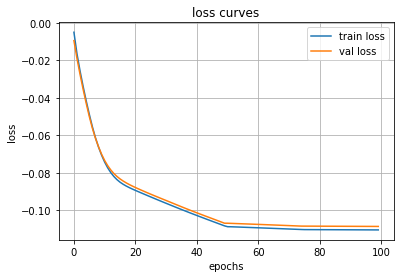

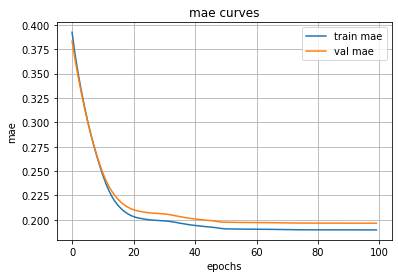

training estimator #  1
Train on 12750 samples, validate on 4250 samples
Epoch 1/100
12750/12750 - 0s - loss: 0.0041 - mae: 0.4163 - val_loss: -4.2806e-03 - val_mae: 0.4018 - lr: 0.0010 - 443ms/epoch - 35us/sample
Epoch 2/100
12750/12750 - 0s - loss: -1.3859e-02 - mae: 0.3914 - val_loss: -2.1138e-02 - val_mae: 0.3781 - lr: 0.0010 - 52ms/epoch - 4us/sample
Epoch 3/100
12750/12750 - 0s - loss: -2.8455e-02 - mae: 0.3705 - val_loss: -3.5475e-02 - val_mae: 0.3570 - lr: 0.0010 - 75ms/epoch - 6us/sample
Epoch 4/100
12750/12750 - 0s - loss: -4.1523e-02 - mae: 0.3509 - val_loss: -4.9737e-02 - val_mae: 0.3354 - lr: 0.0010 - 38ms/epoch - 3us/sample
Epoch 5/100
12750/12750 - 0s - loss: -5.5068e-02 - mae: 0.3302 - val_loss: -6.4319e-02 - val_mae: 0.3130 - lr: 0.0010 - 63ms/epoch - 5us/sample
Epoch 6/100
12750/12750 - 0s - loss: -6.8941e-02 - mae: 0.3088 - val_loss: -7.8591e-02 - val_mae: 0.2913 - lr: 0.0010 - 37ms/epoch - 3us/sample
Epoch 7/100
12750/12750 - 0s - loss: -8.2402e-02 - mae: 0.2881 - v

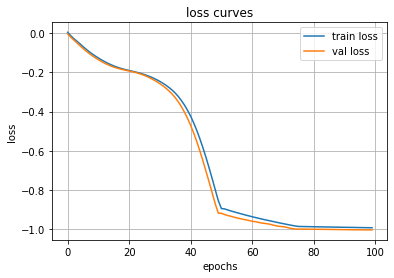

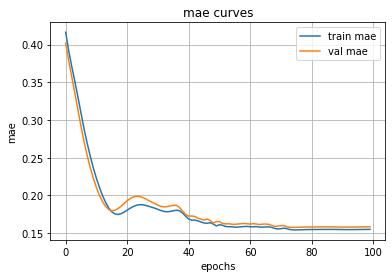

training estimator #  2
Train on 12750 samples, validate on 4250 samples
Epoch 1/100
12750/12750 - 0s - loss: 0.0259 - mae: 0.4763 - val_loss: 0.0133 - val_mae: 0.4590 - lr: 0.0010 - 209ms/epoch - 16us/sample
Epoch 2/100
12750/12750 - 0s - loss: 0.0074 - mae: 0.4510 - val_loss: -1.9311e-03 - val_mae: 0.4374 - lr: 0.0010 - 27ms/epoch - 2us/sample
Epoch 3/100
12750/12750 - 0s - loss: -7.7857e-03 - mae: 0.4293 - val_loss: -1.3755e-02 - val_mae: 0.4199 - lr: 0.0010 - 22ms/epoch - 2us/sample
Epoch 4/100
12750/12750 - 0s - loss: -1.9661e-02 - mae: 0.4114 - val_loss: -2.2733e-02 - val_mae: 0.4058 - lr: 0.0010 - 24ms/epoch - 2us/sample
Epoch 5/100
12750/12750 - 0s - loss: -2.8925e-02 - mae: 0.3969 - val_loss: -3.0372e-02 - val_mae: 0.3934 - lr: 0.0010 - 33ms/epoch - 3us/sample
Epoch 6/100
12750/12750 - 0s - loss: -3.7014e-02 - mae: 0.3840 - val_loss: -3.7274e-02 - val_mae: 0.3821 - lr: 0.0010 - 23ms/epoch - 2us/sample
Epoch 7/100
12750/12750 - 0s - loss: -4.4426e-02 - mae: 0.3722 - val_loss: -

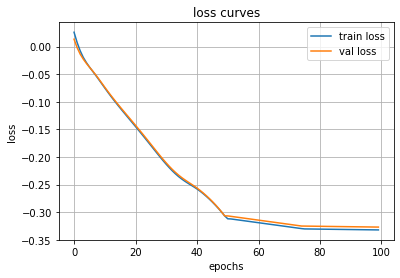

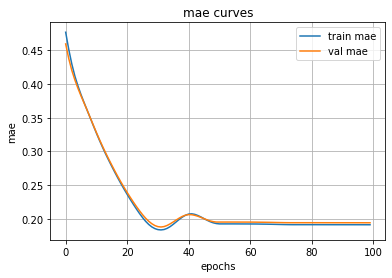

training estimator #  3
Train on 12750 samples, validate on 4250 samples
Epoch 1/100
12750/12750 - 0s - loss: -2.5914e-02 - mae: 0.3283 - val_loss: -3.3709e-02 - val_mae: 0.3214 - lr: 0.0010 - 216ms/epoch - 17us/sample
Epoch 2/100
12750/12750 - 0s - loss: -3.6822e-02 - mae: 0.3151 - val_loss: -4.5459e-02 - val_mae: 0.3070 - lr: 0.0010 - 31ms/epoch - 2us/sample
Epoch 3/100
12750/12750 - 0s - loss: -4.8329e-02 - mae: 0.3006 - val_loss: -5.7184e-02 - val_mae: 0.2918 - lr: 0.0010 - 26ms/epoch - 2us/sample
Epoch 4/100
12750/12750 - 0s - loss: -5.9865e-02 - mae: 0.2850 - val_loss: -6.8522e-02 - val_mae: 0.2765 - lr: 0.0010 - 24ms/epoch - 2us/sample
Epoch 5/100
12750/12750 - 0s - loss: -7.1040e-02 - mae: 0.2694 - val_loss: -7.9103e-02 - val_mae: 0.2616 - lr: 0.0010 - 27ms/epoch - 2us/sample
Epoch 6/100
12750/12750 - 0s - loss: -8.1492e-02 - mae: 0.2544 - val_loss: -8.8603e-02 - val_mae: 0.2478 - lr: 0.0010 - 26ms/epoch - 2us/sample
Epoch 7/100
12750/12750 - 0s - loss: -9.0853e-02 - mae: 0.240

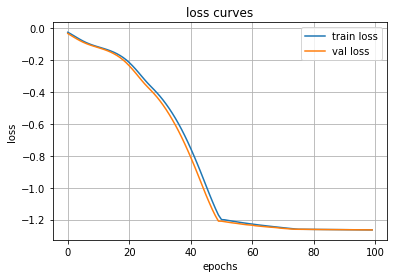

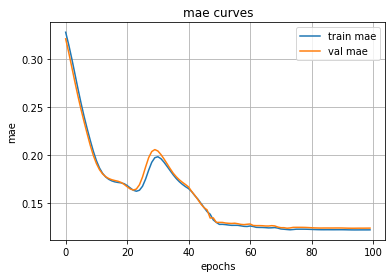

training estimator #  4
Train on 12750 samples, validate on 4250 samples
Epoch 1/100
12750/12750 - 0s - loss: -1.4625e-02 - mae: 0.4305 - val_loss: -2.3009e-02 - val_mae: 0.4176 - lr: 0.0010 - 253ms/epoch - 20us/sample
Epoch 2/100
12750/12750 - 0s - loss: -2.6330e-02 - mae: 0.4130 - val_loss: -3.4543e-02 - val_mae: 0.4005 - lr: 0.0010 - 27ms/epoch - 2us/sample
Epoch 3/100
12750/12750 - 0s - loss: -3.7530e-02 - mae: 0.3961 - val_loss: -4.5264e-02 - val_mae: 0.3847 - lr: 0.0010 - 27ms/epoch - 2us/sample
Epoch 4/100
12750/12750 - 0s - loss: -4.7949e-02 - mae: 0.3805 - val_loss: -5.4577e-02 - val_mae: 0.3713 - lr: 0.0010 - 33ms/epoch - 3us/sample
Epoch 5/100
12750/12750 - 0s - loss: -5.7310e-02 - mae: 0.3667 - val_loss: -6.2739e-02 - val_mae: 0.3600 - lr: 0.0010 - 31ms/epoch - 2us/sample
Epoch 6/100
12750/12750 - 0s - loss: -6.5460e-02 - mae: 0.3551 - val_loss: -7.0114e-02 - val_mae: 0.3501 - lr: 0.0010 - 33ms/epoch - 3us/sample
Epoch 7/100
12750/12750 - 0s - loss: -7.2703e-02 - mae: 0.345

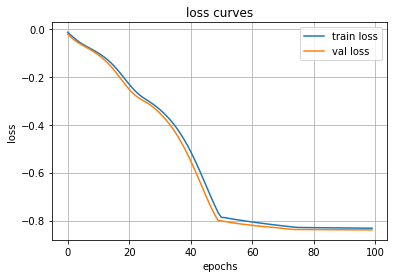

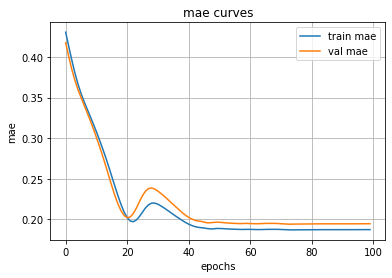

training estimator #  5
Train on 12750 samples, validate on 4250 samples
Epoch 1/100
12750/12750 - 0s - loss: -8.9847e-02 - mae: 0.3623 - val_loss: -1.0087e-01 - val_mae: 0.3452 - lr: 0.0010 - 256ms/epoch - 20us/sample
Epoch 2/100
12750/12750 - 0s - loss: -1.1380e-01 - mae: 0.3350 - val_loss: -1.2385e-01 - val_mae: 0.3188 - lr: 0.0010 - 31ms/epoch - 2us/sample
Epoch 3/100
12750/12750 - 0s - loss: -1.3816e-01 - mae: 0.3075 - val_loss: -1.4725e-01 - val_mae: 0.2933 - lr: 0.0010 - 30ms/epoch - 2us/sample
Epoch 4/100
12750/12750 - 0s - loss: -1.6278e-01 - mae: 0.2811 - val_loss: -1.7103e-01 - val_mae: 0.2691 - lr: 0.0010 - 33ms/epoch - 3us/sample
Epoch 5/100
12750/12750 - 0s - loss: -1.8755e-01 - mae: 0.2568 - val_loss: -1.9500e-01 - val_mae: 0.2473 - lr: 0.0010 - 35ms/epoch - 3us/sample
Epoch 6/100
12750/12750 - 0s - loss: -2.1234e-01 - mae: 0.2352 - val_loss: -2.1899e-01 - val_mae: 0.2287 - lr: 0.0010 - 27ms/epoch - 2us/sample
Epoch 7/100
12750/12750 - 0s - loss: -2.3680e-01 - mae: 0.216

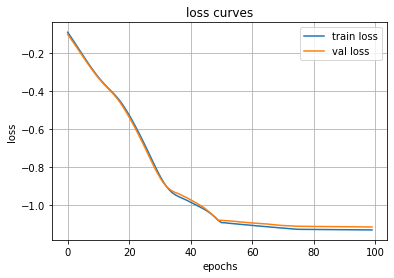

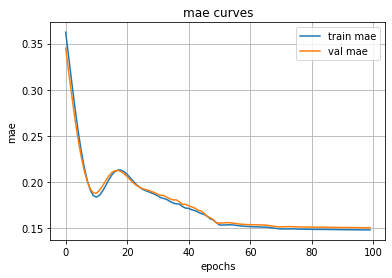

training estimator #  6
Train on 12750 samples, validate on 4250 samples
Epoch 1/100
12750/12750 - 0s - loss: -3.6903e-03 - mae: 0.4232 - val_loss: -1.0183e-02 - val_mae: 0.4102 - lr: 0.0010 - 278ms/epoch - 22us/sample
Epoch 2/100
12750/12750 - 0s - loss: -2.2290e-02 - mae: 0.3923 - val_loss: -2.6129e-02 - val_mae: 0.3807 - lr: 0.0010 - 29ms/epoch - 2us/sample
Epoch 3/100
12750/12750 - 0s - loss: -3.5948e-02 - mae: 0.3646 - val_loss: -3.8301e-02 - val_mae: 0.3540 - lr: 0.0010 - 28ms/epoch - 2us/sample
Epoch 4/100
12750/12750 - 0s - loss: -4.7028e-02 - mae: 0.3395 - val_loss: -4.8755e-02 - val_mae: 0.3301 - lr: 0.0010 - 26ms/epoch - 2us/sample
Epoch 5/100
12750/12750 - 0s - loss: -5.6020e-02 - mae: 0.3187 - val_loss: -5.7281e-02 - val_mae: 0.3104 - lr: 0.0010 - 30ms/epoch - 2us/sample
Epoch 6/100
12750/12750 - 0s - loss: -6.3523e-02 - mae: 0.3016 - val_loss: -6.4802e-02 - val_mae: 0.2932 - lr: 0.0010 - 30ms/epoch - 2us/sample
Epoch 7/100
12750/12750 - 0s - loss: -7.0117e-02 - mae: 0.286

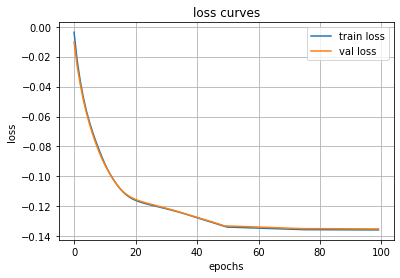

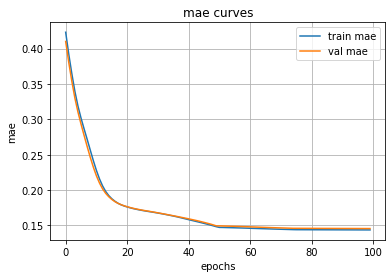

training estimator #  7
Train on 12750 samples, validate on 4250 samples
Epoch 1/100
12750/12750 - 0s - loss: -9.4314e-02 - mae: 0.3427 - val_loss: -1.2198e-01 - val_mae: 0.3060 - lr: 0.0010 - 283ms/epoch - 22us/sample
Epoch 2/100
12750/12750 - 0s - loss: -1.1897e-01 - mae: 0.3068 - val_loss: -1.4491e-01 - val_mae: 0.2734 - lr: 0.0010 - 30ms/epoch - 2us/sample
Epoch 3/100
12750/12750 - 0s - loss: -1.4144e-01 - mae: 0.2746 - val_loss: -1.6557e-01 - val_mae: 0.2468 - lr: 0.0010 - 27ms/epoch - 2us/sample
Epoch 4/100
12750/12750 - 0s - loss: -1.6168e-01 - mae: 0.2482 - val_loss: -1.8380e-01 - val_mae: 0.2274 - lr: 0.0010 - 27ms/epoch - 2us/sample
Epoch 5/100
12750/12750 - 0s - loss: -1.7949e-01 - mae: 0.2285 - val_loss: -1.9960e-01 - val_mae: 0.2145 - lr: 0.0010 - 25ms/epoch - 2us/sample
Epoch 6/100
12750/12750 - 0s - loss: -1.9511e-01 - mae: 0.2140 - val_loss: -2.1283e-01 - val_mae: 0.2069 - lr: 0.0010 - 32ms/epoch - 2us/sample
Epoch 7/100
12750/12750 - 0s - loss: -2.0825e-01 - mae: 0.204

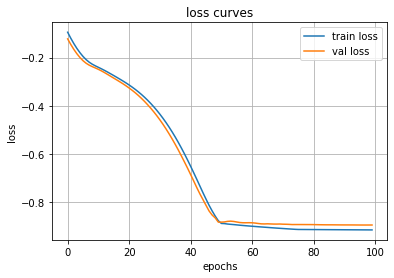

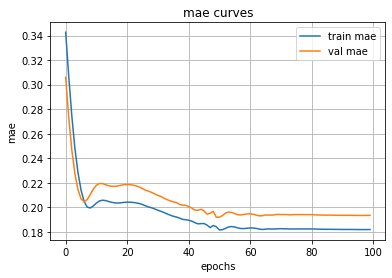

training estimator #  8
Train on 12750 samples, validate on 4250 samples
Epoch 1/100
12750/12750 - 0s - loss: 0.3209 - mae: 0.7845 - val_loss: 0.2491 - val_mae: 0.7079 - lr: 0.0010 - 300ms/epoch - 23us/sample
Epoch 2/100
12750/12750 - 0s - loss: 0.2467 - mae: 0.7087 - val_loss: 0.1823 - val_mae: 0.6353 - lr: 0.0010 - 29ms/epoch - 2us/sample
Epoch 3/100
12750/12750 - 0s - loss: 0.1806 - mae: 0.6373 - val_loss: 0.1241 - val_mae: 0.5675 - lr: 0.0010 - 28ms/epoch - 2us/sample
Epoch 4/100
12750/12750 - 0s - loss: 0.1228 - mae: 0.5705 - val_loss: 0.0739 - val_mae: 0.5049 - lr: 0.0010 - 28ms/epoch - 2us/sample
Epoch 5/100
12750/12750 - 0s - loss: 0.0724 - mae: 0.5085 - val_loss: 0.0310 - val_mae: 0.4480 - lr: 0.0010 - 27ms/epoch - 2us/sample
Epoch 6/100
12750/12750 - 0s - loss: 0.0291 - mae: 0.4518 - val_loss: -5.6866e-03 - val_mae: 0.3969 - lr: 0.0010 - 28ms/epoch - 2us/sample
Epoch 7/100
12750/12750 - 0s - loss: -8.1918e-03 - mae: 0.4006 - val_loss: -3.6898e-02 - val_mae: 0.3517 - lr: 0.001

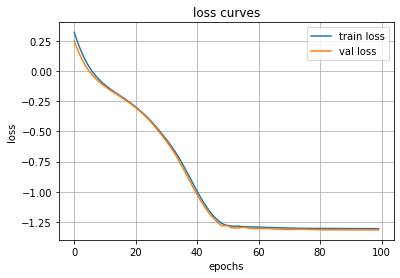

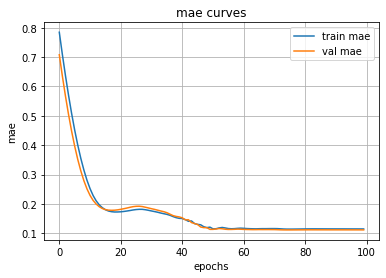

training estimator #  9
Train on 12750 samples, validate on 4250 samples
Epoch 1/100
12750/12750 - 0s - loss: -2.7958e-02 - mae: 0.3968 - val_loss: -2.5638e-02 - val_mae: 0.3986 - lr: 0.0010 - 315ms/epoch - 25us/sample
Epoch 2/100
12750/12750 - 0s - loss: -3.1408e-02 - mae: 0.3914 - val_loss: -2.9113e-02 - val_mae: 0.3933 - lr: 0.0010 - 27ms/epoch - 2us/sample
Epoch 3/100
12750/12750 - 0s - loss: -3.4226e-02 - mae: 0.3868 - val_loss: -3.1957e-02 - val_mae: 0.3887 - lr: 0.0010 - 31ms/epoch - 2us/sample
Epoch 4/100
12750/12750 - 0s - loss: -3.6684e-02 - mae: 0.3825 - val_loss: -3.4451e-02 - val_mae: 0.3844 - lr: 0.0010 - 31ms/epoch - 2us/sample
Epoch 5/100
12750/12750 - 0s - loss: -3.8980e-02 - mae: 0.3784 - val_loss: -3.6766e-02 - val_mae: 0.3803 - lr: 0.0010 - 27ms/epoch - 2us/sample
Epoch 6/100
12750/12750 - 0s - loss: -4.1192e-02 - mae: 0.3744 - val_loss: -3.9000e-02 - val_mae: 0.3763 - lr: 0.0010 - 34ms/epoch - 3us/sample
Epoch 7/100
12750/12750 - 0s - loss: -4.3373e-02 - mae: 0.370

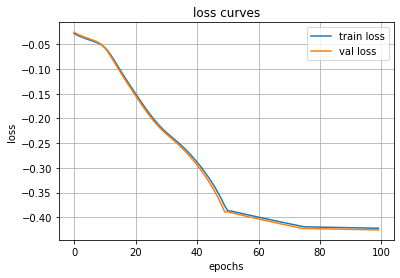

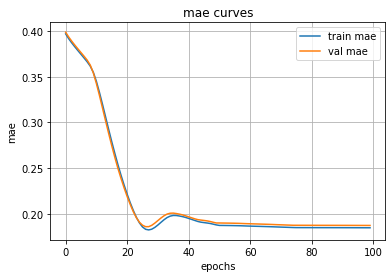

Saved estimator 0 to /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_10.h5/model-ensemble-0.hdf5
Saved estimator 1 to /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_10.h5/model-ensemble-1.hdf5
Saved estimator 2 to /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_10.h5/model-ensemble-2.hdf5
Saved estimator 3 to /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_10.h5/model-ensemble-3.hdf5
Saved estimator 4 to /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_10.h5/model-ensemble-4.hdf5
Saved estimator 5 to /content/drive/MyDrive/MasterThesis/CaliforniaHou

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


intermediate shape of means  (10, 3000, 1)
intermediate shape of variances/stds  (10, 3000, 1)
pred_mean shape  (3000, 1)
pred_std shape  (3000, 1)
prediction mean :
 [[0.47852015]
 [0.41407552]
 [0.4454878 ]
 ...
 [0.26707926]
 [0.37321028]
 [0.5677105 ]]
prediction mean shape  (3000, 1)
prediction std :
 [[0.5199497 ]
 [0.51090276]
 [0.5159521 ]
 ...
 [0.5371726 ]
 [0.5153169 ]
 [0.53843594]]
prediction std shape  (3000, 1)
xxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxx


In [ ]:
#obtained from hyperparameter optimization
def model_function():
    '''
    this model works 
    inp = Input(shape=(8,))
    x = Dense(32, activation='relu')(inp)
    x = Dense(32, activation='relu')(x)
    mean = Dense(1, activation='linear', name='mean')(x)
    var = Dense(1, activation='softplus', name='var')(x)
    '''

    inp = Input(shape=(8,))
    x = Dense(8, activation='relu')(inp)
    x = Dense(8, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    mean = Dense(1, activation='linear', name='mean')(x)
    var = Dense(1, activation='softplus', name='var')(x)


    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])
    #train_model.compile(loss='mse', optimizer='sgd', metrics=['mae'])   

    
    train_model.compile(loss=regression_gaussian_nll_loss(var), optimizer='rmsprop', metrics=['mae'])
    # using sgd yields a very smooth slope

    return train_model, pred_model 
        

# ENSEMBLE MODEL
def train_model(model_func, x_train, y_train, x_val, y_val, x_test, epochs, num_estimators, train_batch_size=None, validation_batch_size=None, test_batch_size=None):
    ens_model = DeepEnsembleRegressor(model_func, num_estimators=num_estimators)

    
    # train a model with stochasticdropout() layer
    history = ens_model.fit(x_train, 
                            y_train, 
                            batch_size=train_batch_size,
                            validation_data=(x_val, y_val), 
                           #val_batch_size=validation_batch_size,
                            verbose=2, 
                            epochs=epochs)
    
    component_min_validation_loss =  [min(history.history['val_loss']) for history in history]  
    component_min_validation_loss_mae =  [min(history.history['val_mae']) for history in history]                               
    
    #saving the model that has custom layers
    ens_model.save(path+'ensemble_model_epochs_'+str(epochs)+'_num_estimators_'+str(num_estimators)+'.h5') 

    pred_mean, pred_std = ens_model.predict_output(x_test, num_ensembles=num_estimators, batch_size=test_batch_size)
    print('pred_mean shape ', pred_mean.shape)
    print('pred_std shape ', pred_std.shape)

    # return the predicted_samples, predicted_mean, predicted_std and model 
    return pred_mean, pred_std, ens_model, component_min_validation_loss, component_min_validation_loss_mae

epochs=100
num_estimators=[10]
#num_estimators=[1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
#num_estimators=[1, 10, 20, 30, 40, 50]
train_batch_size=4096
validation_batch_size=4096
test_batch_size=4096
component_minimum_validation_loss_list = []
component_minimum_validation_loss_mae_list = []


for i in range(len(num_estimators)):
    # running this command creates the stochastic dropout model, trains it and generates the predicted_samples, predicted_mean and predicted_std for the test set (all 3000 examples)
    #prediction_samples, prediction_mean, prediction_std, ensemble_model = train_model(train_data, train_labels, val_data, val_labels, test_data, epochs=epochs, num_estimators=num_estimators)
    prediction_mean, prediction_std, stochastic_model, component_minimum_validation_loss, component_minimum_validation_loss_mae = train_model(model_function, 
                                                                    train_data, 
                                                                    train_labels, 
                                                                    val_data, 
                                                                    val_labels, 
                                                                    test_data, 
                                                                    epochs=epochs, 
                                                                    num_estimators=num_estimators[i],
                                                                    train_batch_size=train_batch_size,
                                                                    validation_batch_size=validation_batch_size,
                                                                    test_batch_size=test_batch_size
                                                                    )
    component_minimum_validation_loss_list.append(component_minimum_validation_loss)
    component_minimum_validation_loss_mae_list.append(component_minimum_validation_loss_mae)


    
    print('prediction mean :\n', prediction_mean)
    print('prediction mean shape ', prediction_mean.shape)
    print('prediction std :\n', prediction_std)
    print('prediction std shape ', prediction_std.shape)
    print('xxxxxxxxxxxxxxxxxxxxxx')
    print('xxxxxxxxxxxxxxxxxxxxxx')
    #print('prediction samples :\n', prediction_samples)
    #print('prediction samples shape ', prediction_samples.shape)
#stochastic_model.summary()

## Ground Truth vs prediction

/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_10.h5
model-ensemble-0.hdf5
model-ensemble-1.hdf5
model-ensemble-2.hdf5
model-ensemble-3.hdf5
model-ensemble-4.hdf5
model-ensemble-5.hdf5
model-ensemble-6.hdf5
model-ensemble-7.hdf5
model-ensemble-8.hdf5
model-ensemble-9.hdf5
metadata.yml
total number of ensemble components :  10


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


intermediate shape of means  (10, 3000, 1)
intermediate shape of variances/stds  (10, 3000, 1)


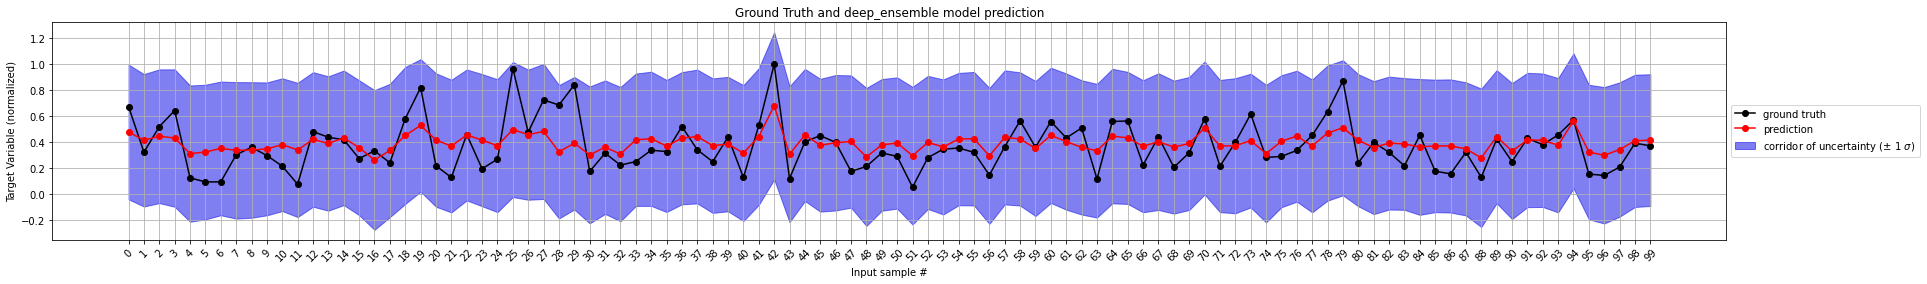

In [ ]:
model = [] 
num_estimators = 0 

model = [] 
num_estimators = 0 
for item in os.listdir(path):
    if '.h5' in item:
        print(path+item)
        for i in os.listdir(path+item):
            print(i)
            if '.hdf5' in i:
                model_variable = tf.keras.models.load_model(path+item+'/'+i)
                model.append(model_variable)
                

print('total number of ensemble components : ', len(model))

# MODEL PREDICTION AND PLOTTING 
stochastic_model = DeepEnsembleRegressor(model_fn=model_function, num_estimators=len(model), models=model)
pred_mean, pred_std = stochastic_model.predict_output(test_data, num_ensembles=len(model)) #we calculate mix_Var but return sqrt of it hence catch it in pred_std

start_index = np.random.randint(test_data.shape[0]-150)
#print('start_index \n ', start_index)

#random = range(start_index, start_index+100)
random = range(0, 100)

#print('random \n ', random)

test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
#print('test labels plot \n ', test_labels_plot)
mean_plot = np.asarray([float(pred_mean[i]) for i in random])
std_plot = np.asarray([float(pred_std[i]) for i in random])

#print('unique value of predicted standard deviation \n ', np.unique(std_plot))

plot_gt_vs_pred(test_labels_plot, mean_plot, std_plot, path+'output_plots/'+uncert_name+'_vs_prediction', random, uncert_name)

## Identify the best number of ensemble components

In [ ]:
'''
if len(num_estimators) > 1:
    #print(component_minimum_validation_loss_list)
    mean_of_best_component_min_validation_loss = [np.mean(i) for i in component_minimum_validation_loss_list]
    #print(mean_of_best_component_min_validation_loss)

    plt.plot(range(1, len(component_minimum_validation_loss_list)+1), mean_of_best_component_min_validation_loss, '-o')
    xticks = [len(i) for i in component_minimum_validation_loss_list]
    print(xticks)
    plt.grid()
    plt.xlabel('# models in ensemble')
    plt.ylabel('mean of best validation loss \nof the models in an ensemble')
    plt.title('Performance of validation loss vs \n# of ensemble components')
    plt.xticks(range(1, len(xticks)+1), xticks)
    plt.savefig(path+'determining_ideal_number_of_ensemble_components.png')
    plt.savefig(path+'determining_ideal_number_of_ensemble_components.pdf')
    plt.show()


    #print(component_minimum_validation_loss_list)
    mean_of_best_component_min_validation_loss_mae = [np.mean(i) for i in component_minimum_validation_loss_mae_list]
    #print(mean_of_best_component_min_validation_loss)

    plt.plot(range(1, len(component_minimum_validation_loss_mae_list)+1), mean_of_best_component_min_validation_loss_mae, '-o')
    xticks = [len(i) for i in component_minimum_validation_loss_mae_list]
    print(xticks)
    plt.grid()
    plt.xlabel('# models in ensemble')
    plt.ylabel('mean of best validation loss \nof the models in an ensemble')
    plt.title('Perfo'rmance of validation loss vs \n# of ensemble components')
    plt.xticks(range(1, len(xticks)+1), xticks)
    plt.savefig(path+'determining_ideal_number_of_ensemble_components_1.png')
    plt.savefig(path+'determining_ideal_number_of_ensemble_components_1.pdf')
    plt.show()
'''

"\nif len(num_estimators) > 1:\n    #print(component_minimum_validation_loss_list)\n    mean_of_best_component_min_validation_loss = [np.mean(i) for i in component_minimum_validation_loss_list]\n    #print(mean_of_best_component_min_validation_loss)\n\n    plt.plot(range(1, len(component_minimum_validation_loss_list)+1), mean_of_best_component_min_validation_loss, '-o')\n    xticks = [len(i) for i in component_minimum_validation_loss_list]\n    print(xticks)\n    plt.grid()\n    plt.xlabel('# models in ensemble')\n    plt.ylabel('mean of best validation loss \nof the models in an ensemble')\n    plt.title('Performance of validation loss vs \n# of ensemble components')\n    plt.xticks(range(1, len(xticks)+1), xticks)\n    plt.savefig(path+'determining_ideal_number_of_ensemble_components.png')\n    plt.savefig(path+'determining_ideal_number_of_ensemble_components.pdf')\n    plt.show()\n\n\n    #print(component_minimum_validation_loss_list)\n    mean_of_best_component_min_validation_loss_

In [ ]:
# Analysis of the input 
num_of_inputs_to_be_explained = 1
start_index = np.random.randint(0, test_data.shape[0])
print('start_index : ', start_index)

test_input = test_data[start_index:start_index+num_of_inputs_to_be_explained]
print('test_input shape :', test_input.shape)

test_input_adj = np.expand_dims(test_input, axis=-1)
print('test_input_adj shape :', test_input_adj.shape)
#prediction_mean, prediction_std, stochastic_model, component_minimum_validation_loss, component_minimum_validation_loss_mae
#pred_mean, pred_std = stochastic_model.predict_output(test_data, num_ensembles=num_estimators, batch_size=test_batch_size)
#print(pred_samples.shape) 
#print('shape of predicted means : ', pred_mean.shape)
#print('shape of predicted std : ', pred_std.shape)
#print('mean \n', pred_mean)
#print('std \n', pred_std)

start_index :  2819
test_input shape : (1, 8)
test_input_adj shape : (1, 8, 1)


In [ ]:
#start_index = np.random.randint(test_data.shape[0]-150)
#random = range(start_index, start_index+100)
#random = range(0, 100)
#print('indices to be plotted \n', random)
#test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
#mean_predictions = np.asarray([float(pred_mean[i]) for i in random])
#std_predictions = np.asarray([float(pred_std[i]) for i in random])

#plot_gt_vs_pred(test_labels_plot, mean_predictions, std_predictions, path+'output_plots/'+uncert_name+'_gt_vs_prediction', random, uncert_name)

## Check to ensure that .layers[-2] yields the pred mean for gbp computation

In [ ]:
inp = Input(shape=(8,))
x = Dense(8, activation='relu')(inp)
x = Dense(8, activation='relu')(x)
x = Dense(8, activation='relu')(x)
mean = Dense(1, activation='relu', name='mean')(x)
var = Dense(1, activation='softplus', name='var')(x)

train_model = Model(inp, mean)
pred_model = Model(inp, [mean, var])
train_model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

train_model.summary() 

list_of_train_layers = train_model.layers
list_of_pred_layers = pred_model.layers

for i in list_of_train_layers:
    print(i.name)
print('xxxxxxxxxxxxxxxxxxx')
for i in list_of_pred_layers:
    print(i.name)

print()

print(pred_model.layers[-2].name)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 8)]               0         
                                                                 
 dense_30 (Dense)            (None, 8)                 72        
                                                                 
 dense_31 (Dense)            (None, 8)                 72        
                                                                 
 dense_32 (Dense)            (None, 8)                 72        
                                                                 
 mean (Dense)                (None, 1)                 9         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
input_11
dense_30
dense_31
dense_32
mean
xxxxxxxxxxxxxxxxxxx

## testing range of regression_gaussian_nll loss

In [ ]:
#regression_gaussian_nll_loss value range test

epsilon = 1e-8
variance_tensor = np.linspace(0, 1, 6)
y_pred = np.linspace(0, 10, 6)
y_true = np.linspace(0, 10, 6)

print(y_pred)
print(y_true)

reg_nll = 0.5 * np.mean(np.log(variance_tensor + epsilon) + np.square(y_true - y_pred) / (variance_tensor + epsilon))

print(reg_nll)

[ 0.  2.  4.  6.  8. 10.]
[ 0.  2.  4.  6.  8. 10.]
-1.8066982040978463


In [ ]:
#import tensorflow as tf 
#from tensorflow.keras.layers import * 
#from tensorflow.keras.models import Sequential

#model = Sequential()
#model.add(Dense(32, activation='relu'))
#model.add(Dense(32, activation='relu'))
#model.add(Dense(32, activation='relu'))
#model.add(Dense(1, activation='linear', name='mean'))
#model.build((8,1))
#model.summary()

#var = Dense(1, activation='softplus', name='var')(x)